# Feed calculator

In [16]:
import pandas as pd
from pulp import *

# Basic Model

## Process the dataset

In [17]:
pd.set_option('display.max_columns', 500) #To show all the columns when neccessary
df = pd.read_excel("nutrition.xlsx",nrows=64)

In [18]:
df.columns = ['ingredient' if col.startswith('INGREDIENT') else col for col in df]

In [19]:
food_items = list(df['ingredient'])

In [20]:
print("So, the food items to consdier, are\n"+"-"*100)
for f in food_items:
    print(f,end=', ')

So, the food items to consdier, are
----------------------------------------------------------------------------------------------------
barley, blood, boneash, copra, cotton, fats, fish, fishlq, gnseeds, gncake, maize, maizebranhighq, maizebranlowq, mbmeal, sugars, pkcake, palmoil, rapecake, rapemeal, rice, sesamecake, sorghum, soybeanexp, soybeanhulls, soybeanmeal, soybeanheat, sunflower, sunflowerseeds, tapbran, caswhole, casfine, cascoarse, wheat, wheatbran, dicaph, monocapo, lime, shells, salt, 

In [21]:
import numpy as np
df.shape

(39, 73)

In [22]:
np.random.seed(0)
# df['Price/kg'] = random.rand(39,1)*10
df['Price/kg'] = np.ones(39)*10

In [23]:
nutrition_df=pd.read_excel('quantity.xlsx')

In [35]:
df

,ingredient,dm,moist,ash,cp,cfat,cfibre,staew,sug,cho,ca,p,ip,k,na,cl,oebr,oelh,opp,lys,met,cys,mc,thr,trp,ile,arg,phe,his,leu,tyr,phetyr,val,dlysp,dmetp,dcysp,dmcp,dthrp,dtryp,dilep,dargp,dvalp,dneaa,c182,c20,ne2015mj,ne2015kcal,ewcvb2015,vppi,sidlys,sidmet,sidcys,sidmc,sidthr,sidtrp,sidile,sidneaa,decat,pcat,alyscat,ametcat,acyscat,amccat,athrcat,atrpcat,ailecat,aargcat,aphecat,ahiscat,aleucat,atyrcat,aptcat,avalcat,Price/kg
0,barley,867,133,19.941,99.705,27.000,43.350,539.274,22.542,0.000,0.4335,3.1212,2.3409,4.9419,0.0867,1.0404,2656.488,2861.967,1.2138,3.554700,1.734000,2.167500,3.901500,3.381300,1.21380,3.468000,4.855200,0.000000,0.000000,0.000000,0.000000,0.000000,4.855200,2.340900,1.300500,1.560600,2.861100,2.254200,0.867000,2.514300,3.901500,3.641400,41.009100,6.8493,0.0000,9.996510,2389.452000,1.135770,0.9537,2.68770,1.387200,1.734000,3.121200,2.687700,0.953700,2.861100,44.910600,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.0
1,blood,890,110,25.000,800.000,10.000,10.000,0.000,0.000,80.000,0.5000,1.7000,0.0000,2.7570,5.7897,3.4003,2450.000,2450.000,1.3000,71.201629,9.613035,9.613035,19.226069,35.193483,11.97556,9.613035,34.378819,55.226947,51.237842,102.475683,23.225458,78.452404,68.839104,51.250509,6.892057,6.892057,13.784114,25.368635,8.651731,6.892057,24.782077,49.564155,239.828921,0.0000,0.0000,7.185336,1716.415479,0.813849,1.0109,60.04888,7.625255,7.625255,15.250509,28.008147,9.824847,6.452138,263.584521,3690.000000,1.00300,59.595764,7.527006,7.440489,14.900000,27.556497,9.700204,6.229246,29.084481,45.727912,43.347214,85.772147,18.185533,63.900000,56.998778,10.0
2,boneash,954,46,806.130,0.000,0.000,0.000,0.000,0.000,0.000,289.2528,133.7508,0.0000,0.3816,9.5400,0.0000,0.000,0.000,82.9000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,87.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.00064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.0
3,copra,907,93,60.769,203.168,89.000,113.375,13.605,100.677,0.000,0.8163,5.5327,2.7210,21.2238,0.6349,6.1676,1889.000,1889.281,2.6303,5.079200,3.083800,3.083800,6.167600,6.076900,1.45120,6.530400,22.221500,0.000000,0.000000,0.000000,0.000000,0.000000,9.795600,2.358200,2.448900,1.632600,4.081500,3.628000,0.997700,4.897800,19.047000,7.528100,59.952700,1.2698,0.0000,9.051860,2163.195000,1.024910,1.2698,2.90240,1.814000,1.814000,3.628000,3.537300,0.816300,3.809400,49.522200,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.0
4,cotton,933,67,59.712,362.937,79.000,169.806,33.588,38.253,0.000,2.2392,10.1697,7.6506,14.3682,0.0000,0.2799,1730.000,1890.258,3.0789,14.928000,5.784600,6.157800,11.942400,11.662500,4.38510,11.289300,38.812800,0.000000,0.000000,0.000000,0.000000,0.000000,15.954300,8.770200,3.918600,4.198500,8.117100,8.023800,3.172200,8.117100,32.655000,11.849100,125.395200,28.3632,0.5598,6.829560,1633.683000,0.774390,2.8923,10.35630,4.665000,4.944900,9.609900,8.863500,3.545400,8.956800,139.763400,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.0
5,fats,995,5,0.000,0.000,995.000,0.000,0.000,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7230.000,9770.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.0000,35.0000,31.790000,7600.000000,3.610000,0.0000,0.00000,0.000000,0.000000,0.00000

## Dealing with costs

In [24]:
cost_df_raw=pd.read_excel('costs.xlsx')

In [25]:
food_items_df=pd.DataFrame(food_items,columns=['food'])

In [26]:
costs_df=food_items_df.merge(cost_df_raw,left_on='food',right_on='Ingredients')

In [27]:
costs_df=costs_df.drop('food',axis=1)

In [28]:
costs={}
for i in range (len(costs_df)):
    costs[costs_df['Ingredients'].iloc[i]]=costs_df['Price'].iloc[i]

In [29]:
print(costs)
len(costs)

{'barley': 105, 'blood': 285, 'boneash': 70, 'copra': 65, 'cotton': 80, 'fats': 600, 'fish': 250, 'fishlq': 220, 'gnseeds': 235, 'gncake': 200, 'maize': 130, 'maizebranhighq': 75, 'maizebranlowq': 60, 'mbmeal': 135, 'sugars': 85, 'pkcake': 50, 'palmoil': 600, 'rapecake': 125, 'rapemeal': 87, 'rice': 45, 'sesamecake': 97, 'sorghum': 150, 'soybeanexp': 150, 'soybeanhulls': 30, 'soybeanmeal': 150, 'soybeanheat': 250, 'sunflower': 81, 'sunflowerseeds': 195, 'tapbran': 90, 'caswhole': 60, 'casfine': 70, 'cascoarse': 65, 'wheat': 110, 'wheatbran': 70, 'dicaph': 350, 'monocapo': 375, 'lime': 20, 'shells': 45, 'salt': 100}


39

# Extension 1-1

Question: At most MaxNum of ingredients to use. 

In [30]:
def cost_calculation(MaxNum,food_items,nutrition_df):
    #Extract all the nutritions included
    nutrition=[]
    for i in range (len(nutrition_df)):
        nutrition.append(nutrition_df.iloc[i][0])
    #Create dictionay for every single nutrition. The dictionary includes the amount contained in different ingredient.
    for i in range(len(nutrition)):
        vars()[nutrition[i]] = dict(zip(food_items,df[nutrition[i]]))
    
    food_vars = LpVariable.dicts("Portion",food_items,lowBound=0,cat='Continuous')
    
    food_chosen = LpVariable.dicts("Chosen",food_items,0,1,cat='Integer')
    
    prob2 = LpProblem("Smallholder Layer Starter Diet",LpMinimize)

    # The objective function is added to 'prob' first
    prob2 += lpSum([costs[i]*food_vars[i] for i in food_items]), "Total Cost of the balanced diet"

    for i in range(len(nutrition_df)):
        n = vars()[nutrition_df.iloc[i,0]]
        prob2 += lpSum([n[f]* food_vars[f] for f in food_items]) >= nutrition_df['Minimum'][i]
        if (i in nutrition_df[nutrition_df['Maximum']>0].index):
            prob2 += lpSum([n[f]* food_vars[f] for f in food_items]) <= nutrition_df['Maximum'][i]

    for f in food_items:
        prob2 += food_vars[f]>= 0

        prob2 += food_vars[f]<= food_chosen[f]*1e5
    prob2+= lpSum([food_chosen[f] for f in food_items])<=MaxNum
    # The problem is solved using PuLP's choice of Solver
    prob2.solve(pulp.PULP_CBC_CMD())

    return round(value(prob2.objective),2)

In [31]:
cost_vec=[]
MaxNumVec=[]
for MaxNum in range (3,12):
    cost=cost_calculation(MaxNum,food_items,nutrition_df)
    MaxNumVec.append(MaxNum)
    cost_vec.append(cost)

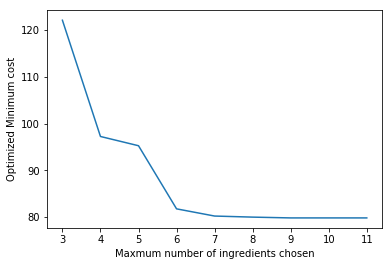

In [34]:
import matplotlib.pyplot as plt
plt.plot(MaxNumVec,cost_vec)
plt.ylabel('Optimized Minimum cost')
plt.xlabel('Maxmum number of ingredients chosen')
plt.show()

In [33]:
cost_vec

[122.11, 97.23, 95.25, 81.74, 80.2, 79.97, 79.8, 79.8, 79.8]